In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy
from skimage.transform import resize
import nibabel as nib
import os

from torch_vis import * # all relevant code in torch_vis.py

In [3]:
def load_pet_slice(filename, slice_number):
    # loads PET image as tensor and normalizes
    # returns both numpy and torch versions
    img = np.array(nib.load(filename).get_fdata())
    img_min = np.min(img)
    img_max = np.max(img)
    img = (img - img_min) / (img_max - img_min)
    torch_img = torch.Tensor(img)
    return img[:,:,slice_number,0], torch_img[:,:,slice_number,0].unsqueeze(0).unsqueeze(0)

### Run for all holdout images

In [4]:
# Get LRP for all slices for all images in holdout set 
all_images = os.listdir("data/pet_holdout")
all_slices = list(range(30, 70, 4))
model_paths = ["models/pet/2D_Slice_{}".format(i) for i in all_slices]

In [5]:
def get_all_lrp_maps(images, slices, rel_for_class = 0, beta = 0.25):
    # set up dictionary for results
    # for each image, store lrp map for each slice
    # - key: image filename
    # - value: {slice number : lrp map (np array)}
    lrp_maps = {img_name : dict() for img_name in images}

    for slice_num in slices:
        # load model    
        model = ClassificationModel2D()
        model.load_state_dict(torch.load("models/pet/2D_Slice_{}".format(slice_num)))
        model.eval()

        # run through all images
        for image_name in images:
            img, torch_img = load_pet_slice("data/pet_holdout/" + image_name,  slice_num)
            lrp_map = lrp_image(model, torch_img, rel_for_class, beta)
            lrp_maps[image_name][slice_num] = lrp_map
    return lrp_maps

In [6]:
all_maps0 = get_all_lrp_maps(all_images, all_slices, rel_for_class = 0)
# all_maps1 = get_all_lrp_maps(all_images, all_slices, rel_for_class = 1)

In [14]:
# get average across all patients
def show_slice_average(slice_num):
    slice_lrps = np.array([all_maps0[i][slice_num] for i in all_images])
    slice_avg = np.mean(slice_lrps, axis = 0)
    plt.imshow(slice_avg.T, cmap="gray", origin="lower")
    plt.title("Slice {}".format(slice_num))
    plt.xticks([])
    plt.yticks([])

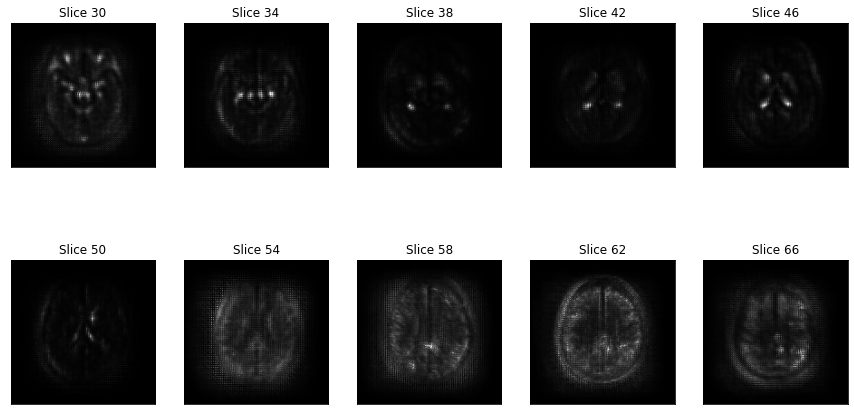

In [16]:
# plot average LRP maps
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    show_slice_average(30 + 4 * i)

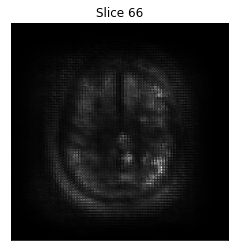

In [17]:
for i in range(30, 70, 4):
    show_slice_average(i)

### Compare averages across healthy and MCI patients

In [18]:
cn_list = ["I871787",  "I856330",  "I977368",  "I856338",  "I935820",  "I915562",  "I1115198", "I1256877", "I964025", 
"I766935",  "I1419733", "I856410",  "I1148991", "I1158506", "I989589",  "I1295250", "I1138260", "I764206", 
"I931447",  "I916039",  "I1229001", "I878103",  "I953402",  "I1070458", "I922543",  "I946873",  "I940452", 
"I1288880", "I718403",  "I1268260", "I968713",  "I1118612", "I948218",  "I1350367", "I1075470", "I940860", 
"I1234692", "I1060182", "I1186597", "I902366",  "I871799",  "I869939"]
cn_list = [cn + ".nii" for cn in cn_list]

mci_list = ["I856322",  "I940428",  "I698114",  "I873780",  "I882016",  "I1043810", "I704939",  "I944272",  "I668869", 
 "I922555",  "I1234708", "I779542",  "I864482",  "I874243",  "I1161819"]
mci_list = [mci + ".nii" for mci in mci_list]

In [19]:
def compare_slice(slice_num):
    slice_lrps_cn = np.array([all_maps0[i][slice_num] for i in cn_list])
    slice_lrps_mci = np.array([all_maps0[i][slice_num] for i in mci_list])

    # then average per pixel
    slice_avg_cn = np.mean(slice_lrps_cn, axis = 0)
    slice_avg_mci = np.mean(slice_lrps_mci, axis = 0)
    avg_cn_norm = (slice_avg_cn - np.min(slice_avg_cn)) / (np.max(slice_avg_cn) - np.min(slice_avg_cn))
    avg_mci_norm = (slice_avg_mci - np.min(slice_avg_mci)) / (np.max(slice_avg_mci) - np.min(slice_avg_mci))
    cn_mci_diff = avg_cn_norm - avg_mci_norm
    
    fig, axes = plt.subplots(1, 3, figsize = (15, 8))
    # average among healthy patients
    axes[0].imshow(slice_avg_cn.T, cmap="gray", origin="lower")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Healthy Average")
    # average among mci patients
    axes[1].imshow(slice_avg_mci.T, cmap="gray", origin="lower")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title("MCI Average")
    # difference 
    diff_im = axes[2].imshow(cn_mci_diff.T, cmap="RdBu", origin="lower")
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title("Difference in Averages")

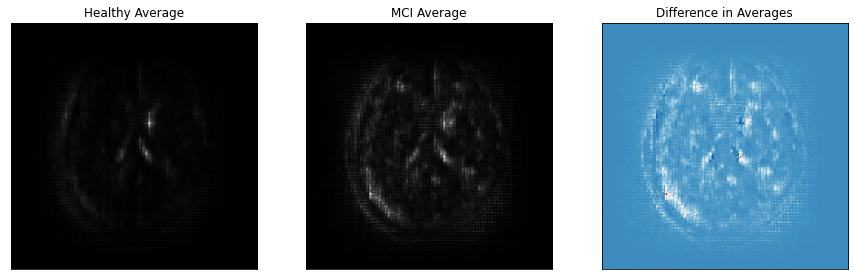

In [20]:
compare_slice(50)

### True Positives

In [75]:
def show_lrps(lrp_maps, images, slice_nums):
    fig, axes = plt.subplots(len(slice_nums), 2 * len(images), figsize = (8 * len(images), 4 * len(slice_nums)))
    for i in range(len(slice_nums)):
        for j in range(2 * len(images)):
            
            if j % 2 == 0: # show original image
                axes[i, j].imshow(load_pet_slice("data/pet_holdout/" + images[j//2], slice_nums[i])[0].T, 
                                  cmap="gray", 
                                  origin="lower")  
                if i == 0: # first in column
                    axes[i, j].set_title("Subject {} PET".format(j//2))
            else:
                axes[i, j].imshow(lrp_maps[images[j//2]][slice_nums[i]].T, cmap="gray", origin="lower")
                if i == 0: # first in column
                    axes[i, j].set_title("Subject {} LRP Map".format(j//2))
            
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            
            if j == 0: # first in row
                axes[i, j].set_ylabel("Slice {}".format(slice_nums[i]), size = "large")
            

In [76]:
tp_images = ["I1043810.nii", "I668869.nii"]

tp_maps = get_all_lrp_maps(tp_images, all_slices, 1, beta = 0.25)

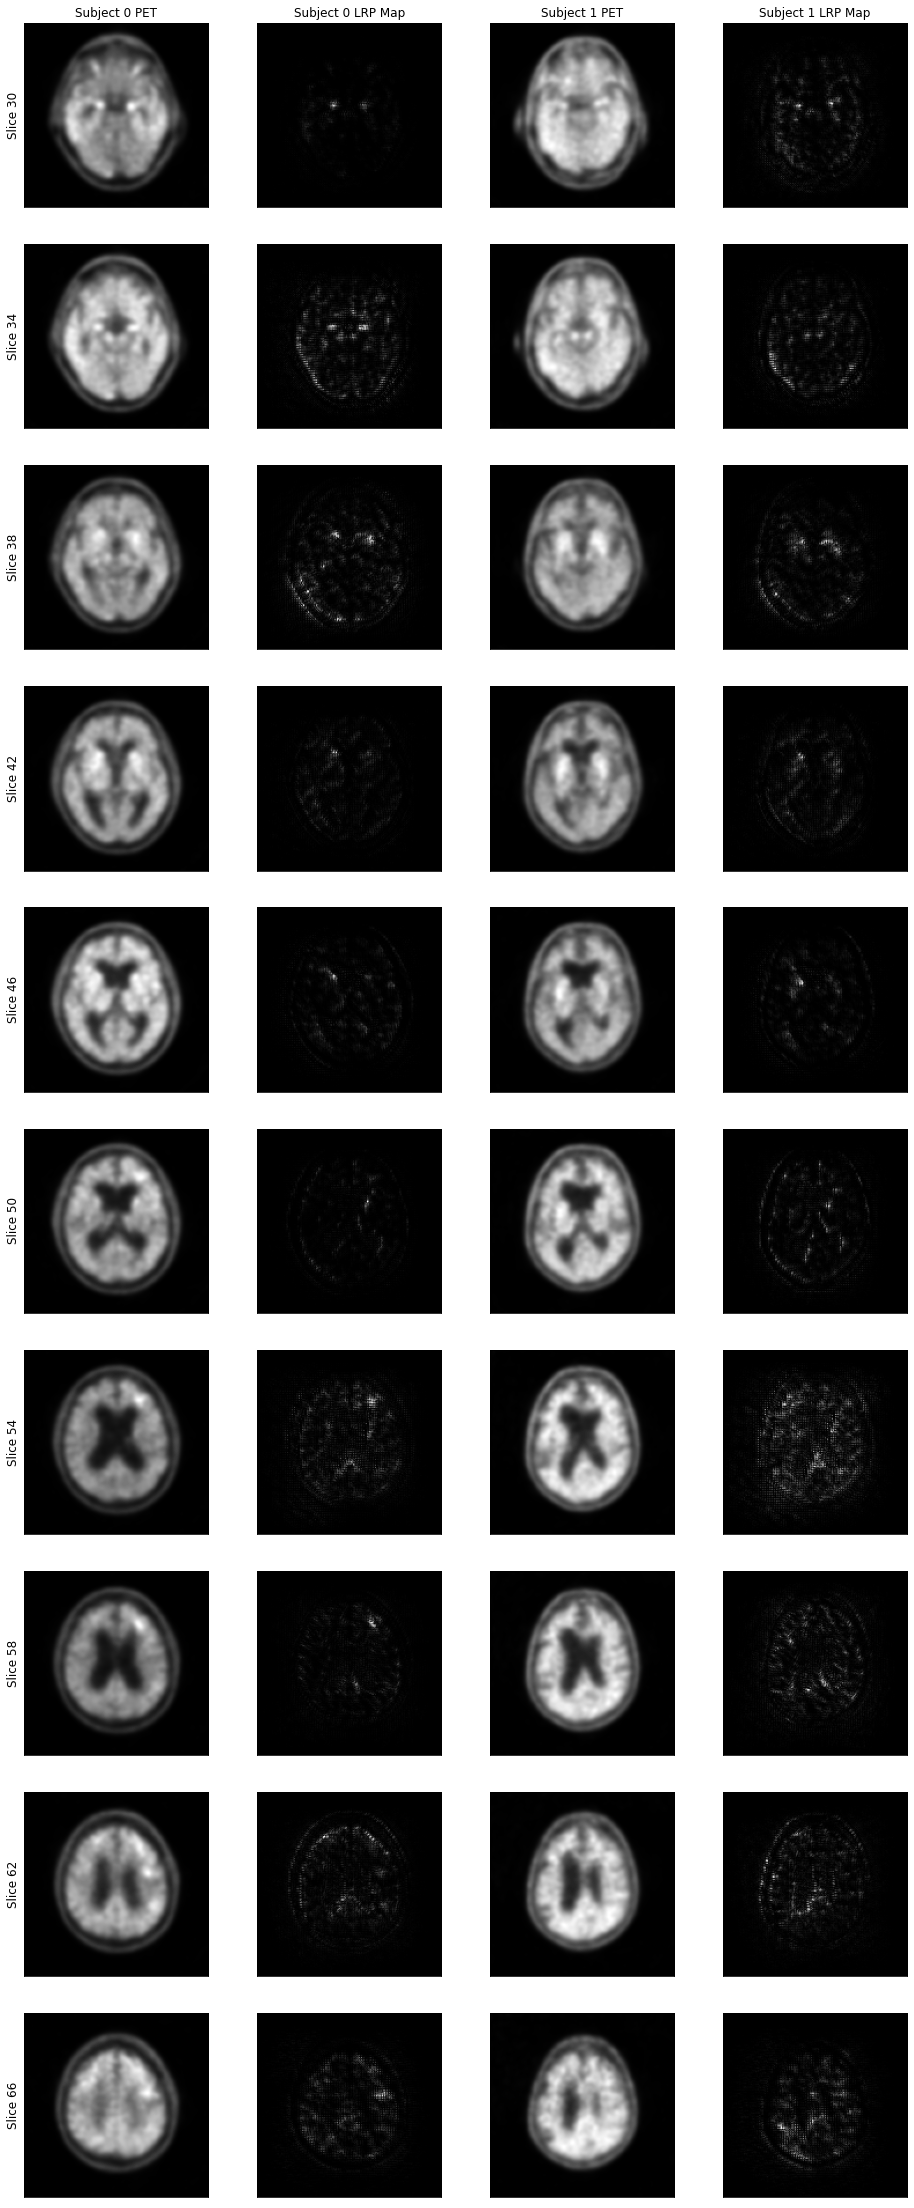

In [77]:
show_lrps(tp_maps, tp_images, all_slices)

### False Positives

In [78]:
fp_images = ["I940452.nii", "I1161819.nii"]

fp_maps = get_all_lrp_maps(fp_images, all_slices, 1, beta = 0.25)

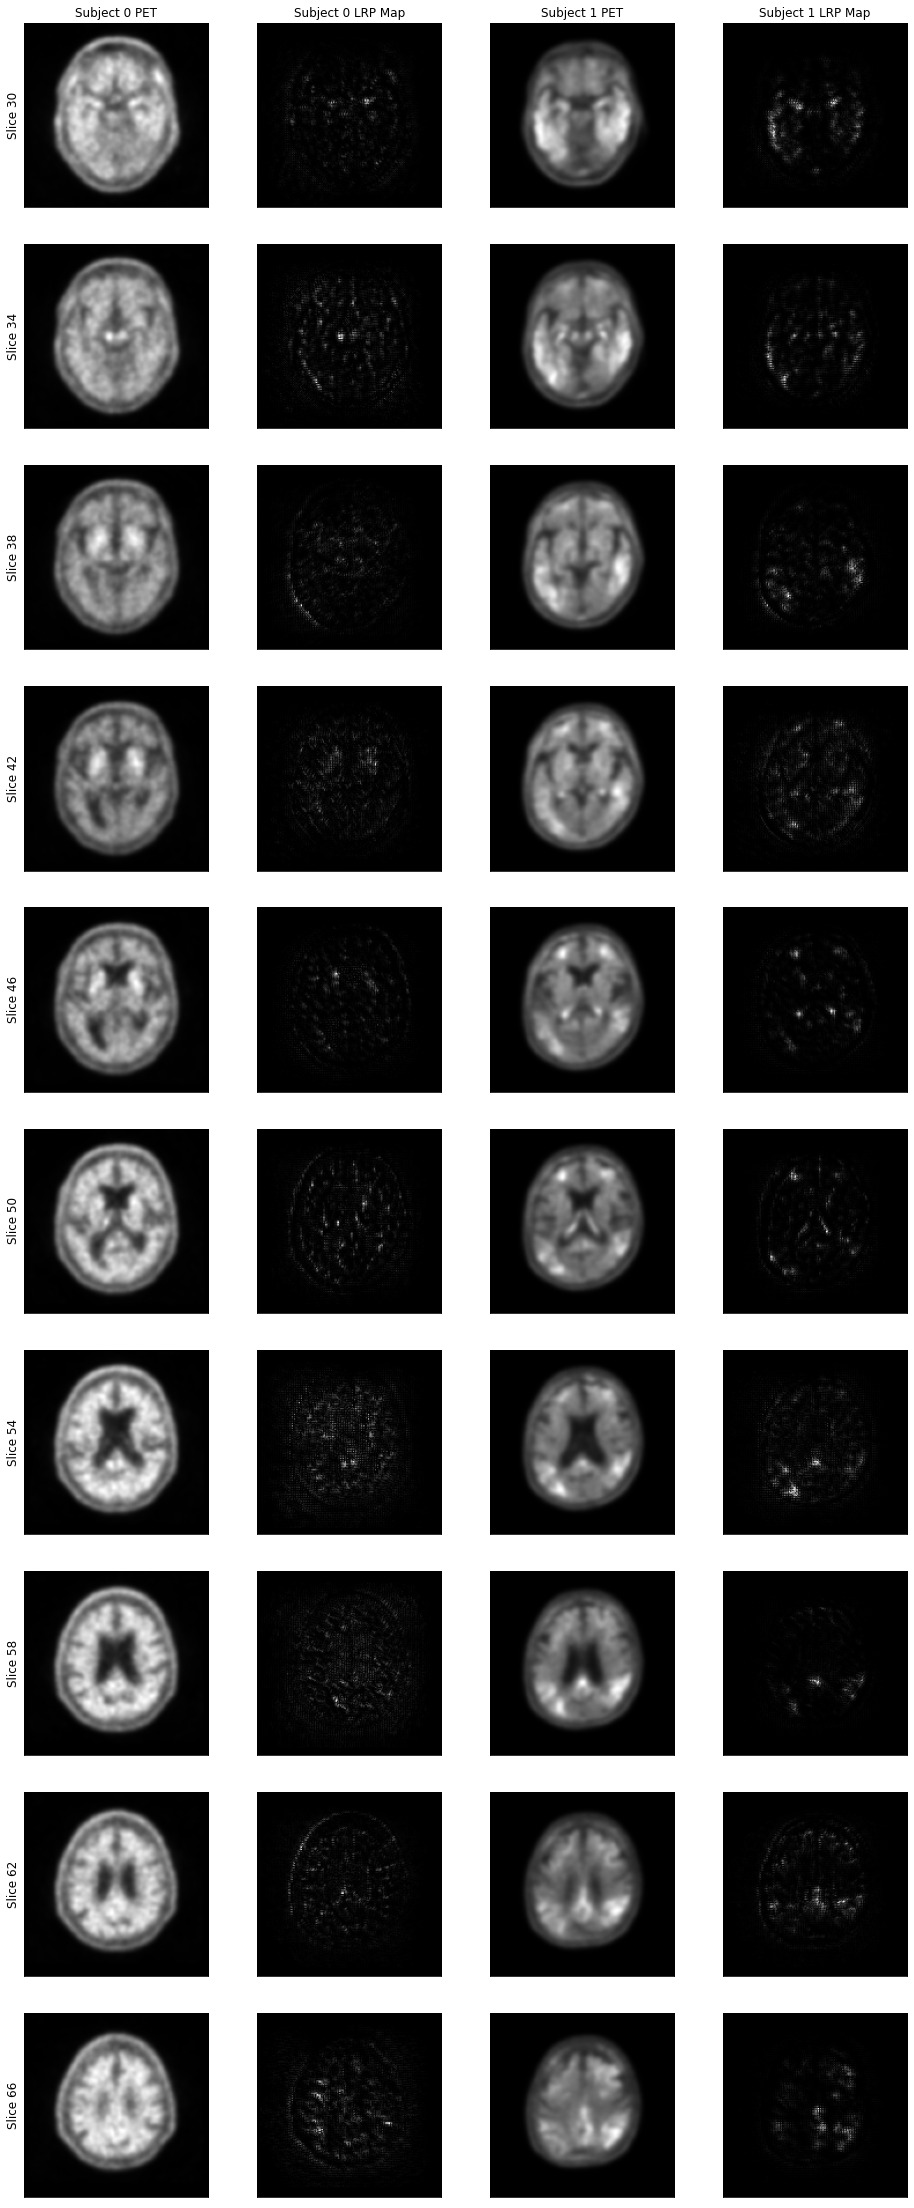

In [79]:
show_lrps(fp_maps, fp_images, all_slices)

### True Negatives

In [80]:
tn_images = ["I871787.nii", "I856330.nii"]
tn_maps = get_all_lrp_maps(tn_images, all_slices, 0, beta = 0.25)

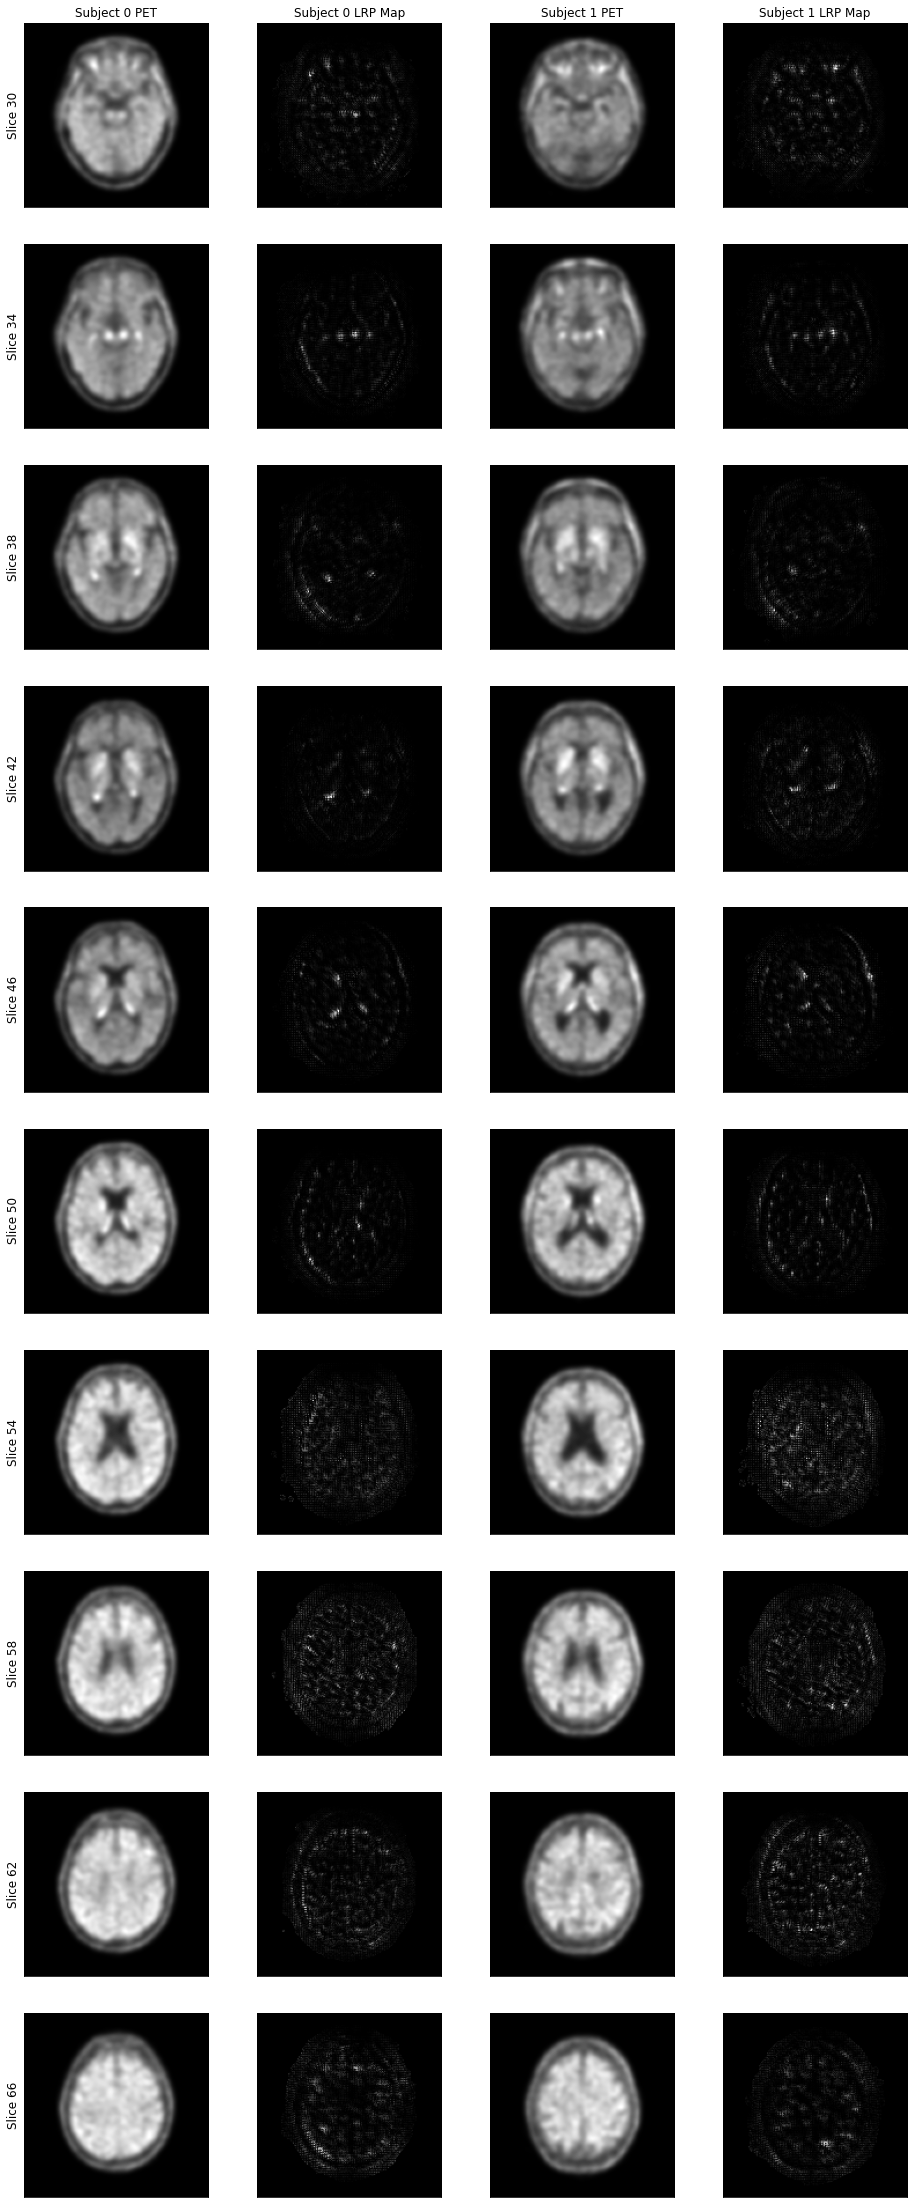

In [81]:
show_lrps(tn_maps, tn_images, all_slices)

### False Negatives

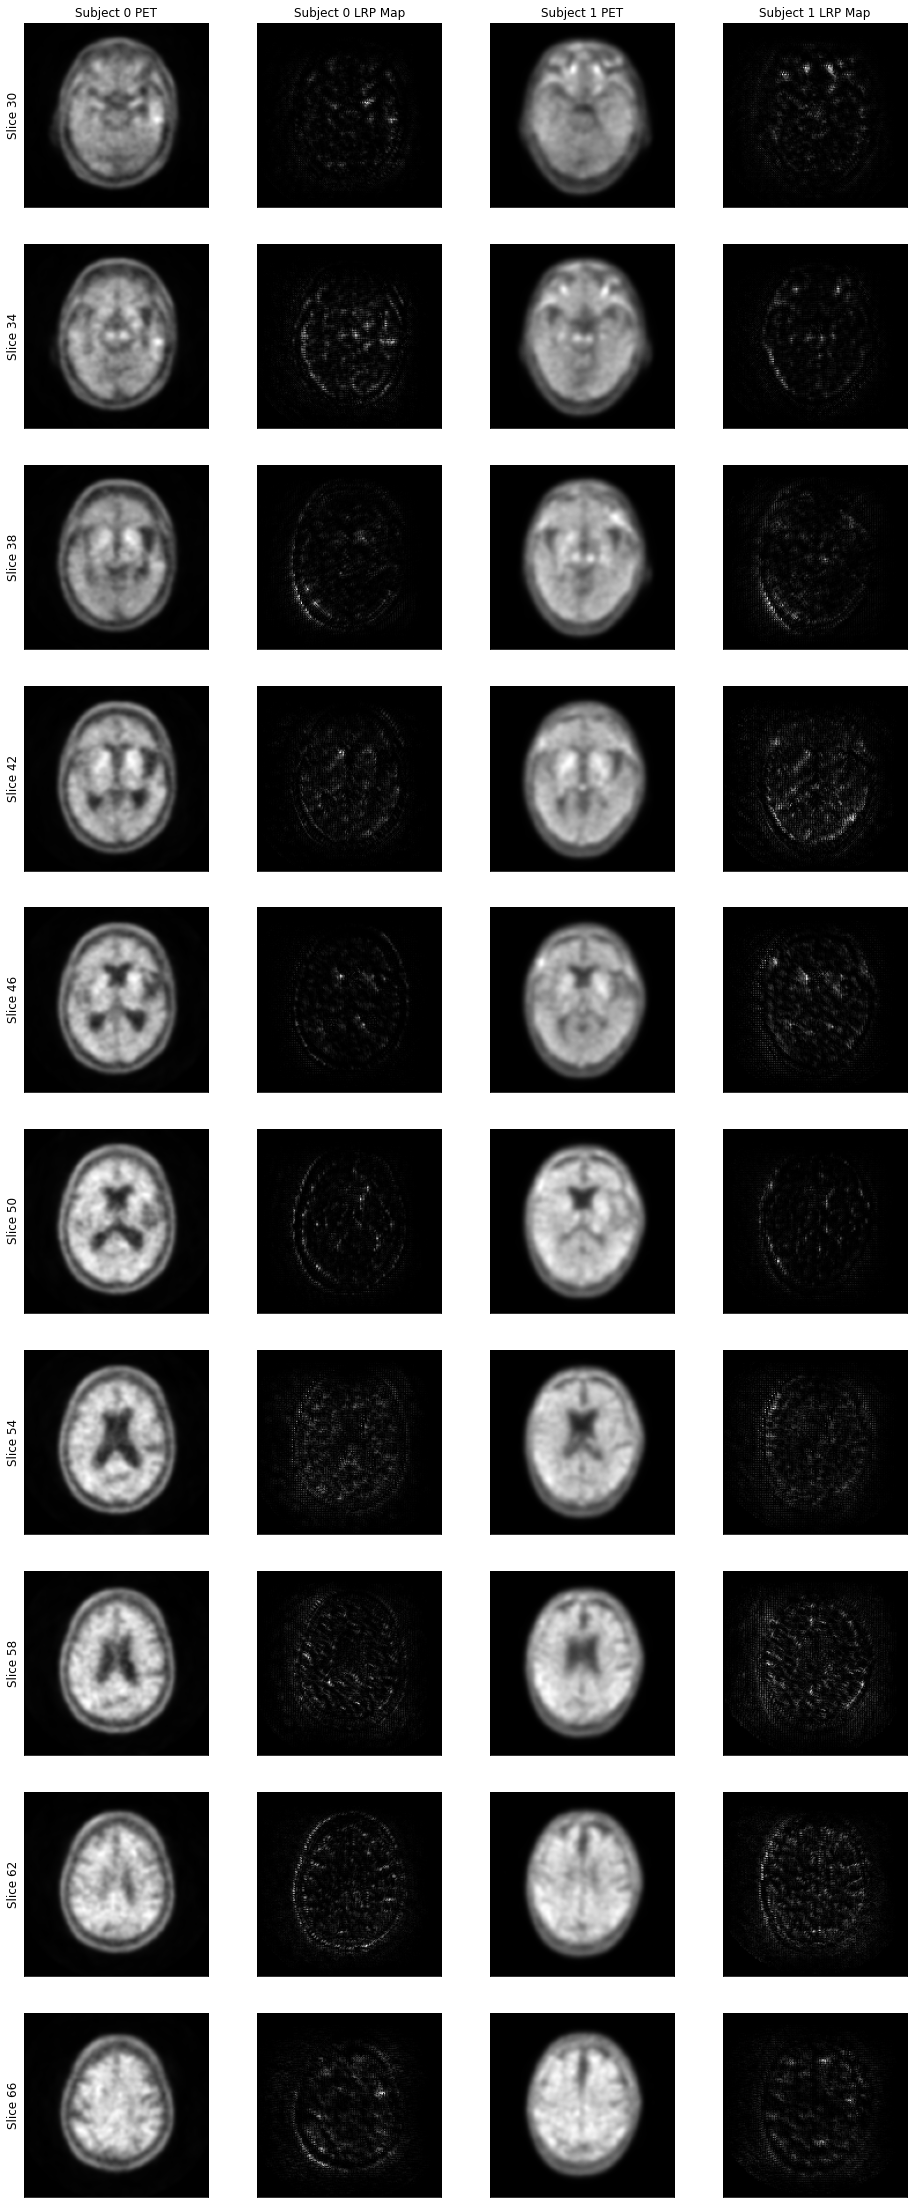

In [82]:
fn_images = ["I698114.nii", "I1234708.nii"]
fn_maps = get_all_lrp_maps(fn_images, all_slices, 0, beta = 0.25)
show_lrps(fn_maps, fn_images, all_slices)

### Compare one slice

In [97]:
comparison_slices = [34, 46]

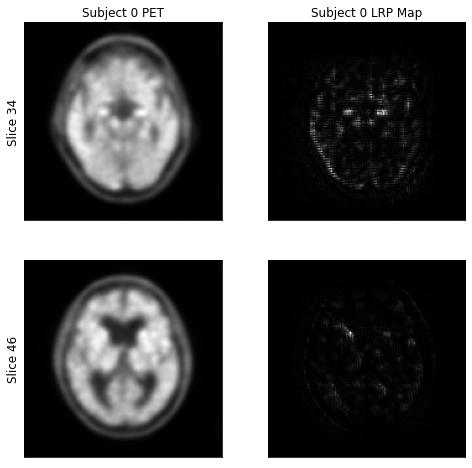

In [98]:
# TP
show_lrps(tp_maps, tp_images[:1], comparison_slices)

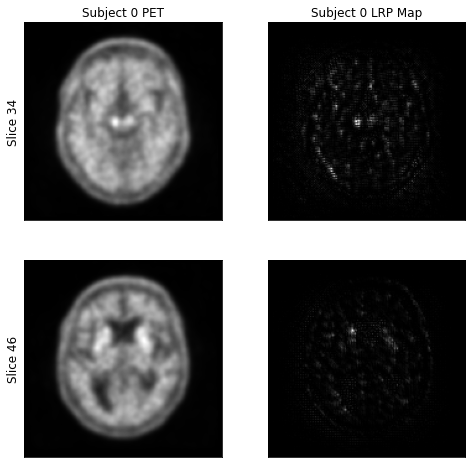

In [99]:
# FP
show_lrps(fp_maps, fp_images[:1], comparison_slices)

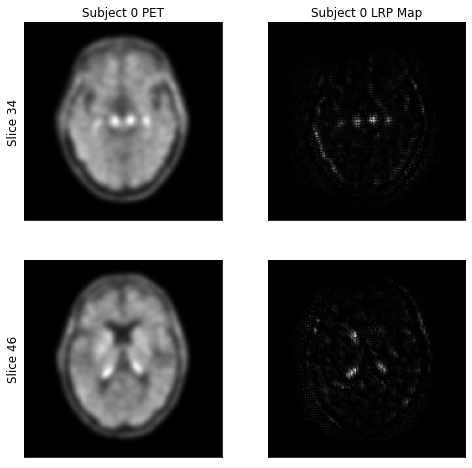

In [100]:
# TN
show_lrps(tn_maps, tn_images[:1], comparison_slices)

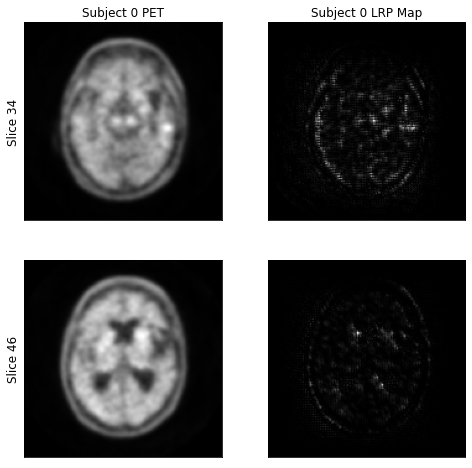

In [101]:
# FN
show_lrps(fn_maps, fn_images[:1], comparison_slices)